In [1]:
from audio_to_text import extract_audio_and_covert_to_text

from state import GraphState

from vectordb import build_vectordb
from retrieval_chain import create_retrieval_chain
from nodes import *

from langgraph.graph import END, StateGraph, START
from langgraph.checkpoint.memory import MemorySaver


from langchain_core.runnables import RunnableConfig
from langchain_teddynote.messages import stream_graph, random_uuid
from langchain_teddynote.graphs import visualize_graph

In [2]:
from dotenv import load_dotenv

load_dotenv()

True

In [3]:
youtube_url = "https://www.youtube.com/shorts/qvswiQSH8Zk"
save_path = "./youtube_audios/"

### Import Modules

In [4]:
text = extract_audio_and_covert_to_text(youtube_url, save_path)

[youtube] Extracting URL: https://www.youtube.com/shorts/qvswiQSH8Zk
[youtube] qvswiQSH8Zk: Downloading webpage
[youtube] qvswiQSH8Zk: Downloading tv client config
[youtube] qvswiQSH8Zk: Downloading tv player API JSON
[youtube] qvswiQSH8Zk: Downloading ios player API JSON
[youtube] qvswiQSH8Zk: Downloading m3u8 information
[info] qvswiQSH8Zk: Downloading 1 format(s): 140
[download] youtube_audios\ZIGZAG meaning ⚡️and CROCODILES 🐊 #learnenglish #vocabulary.m4a has already been downloaded
[download] 100% of  875.09KiB
[ExtractAudio] Not converting audio youtube_audios\ZIGZAG meaning ⚡️and CROCODILES 🐊 #learnenglish #vocabulary.m4a; file is already in target format m4a
Transcribing part 1!
Transcribing part 2!
Transcribing part 3!
Transcribing part 4!
Transcribing part 5!
Transcribing part 6!
Transcribing part 1!


In [5]:
cached_dir = "./embeddingcache/"
db_index = "english_DB_INDEX"
model_name = "text-embedding-3-small"

# Build Vector DB
db = build_vectordb(text, cached_dir, db_index, model_name)

# initialize retriever
retriever = db.as_retriever(search_kwargs={"k": 30})

# initialize retrieval chain
rag_chain = create_retrieval_chain()

### Build Workflow

In [6]:
# Initialize GraphState
workflow = StateGraph(GraphState)

# Define nodes  # Check Language
workflow.add_node("AccentClassifierNode", AccentClassifierNode())  # Classify Accent
workflow.add_node("AccentGraderNode", AccentGraderNode())  # Grade Accent
workflow.add_node("RetrievalNode", RetrievalNode(retriever))  # Retrieve Documents
workflow.add_node("RetrievalAnswerNode", RetrievalAnswerNode(rag_chain))  # Final Answer

# Add Edges
workflow.add_edge(START, "RetrievalNode")

workflow.add_conditional_edges(
    "RetrievalNode",
    LanguageCheckerNode(),
    {
        "english": "AccentClassifierNode",
        "non-English": END,
    },
)
workflow.add_edge("AccentClassifierNode", "AccentGraderNode")
workflow.add_edge("AccentGraderNode", "RetrievalAnswerNode")


# Compile workflow
app = workflow.compile(checkpointer=MemorySaver())

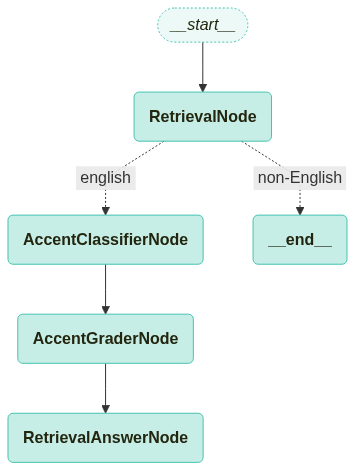

In [7]:
# Visualize Workflow
visualize_graph(app)

In [8]:
# Set config
config = RunnableConfig(recursion_limit=20, configurable={"thread_id": random_uuid()})

# Set Query
inputs = {
    "question": "Please check english aceent",
}

# execute workflow
stream_graph(
    app,
    inputs,
    config,
)


🔄 Node: RetrievalNode 🔄
- - - - - - - - - - - - - - - - - - - - - - - - - 
{"binary_score":"yes"}
🔄 Node: AccentClassifierNode 🔄
- - - - - - - - - - - - - - - - - - - - - - - - - 
{"accent_label":"British"}
🔄 Node: AccentGraderNode 🔄
- - - - - - - - - - - - - - - - - - - - - - - - - 
{"accent_score":95.0}
🔄 Node: RetrievalAnswerNode 🔄
- - - - - - - - - - - - - - - - - - - - - - - - - 
- Classification of the accent: British  
- English accent confidence level: 95.0  
- Summary: The speaker demonstrates a clear British accent with good pronunciation and fluency. Their English is sufficient for professional work.